### Visualizing the history of the ebola Epidemic

**Note** : 
This is last year's exercise analyzing the spread of Ebola. The outbreak has been contained now, nonetheless we will analyze the history of the spread for the 3 of the countries found below. (You can perform up-to-date analysis as well, by changing the dates to 2015 and cutting down the csv content limit to 100 instead of 1000)


The data is available in [this site](http://apps.who.int/gho/data/view.ebola-sitrep.ebola-summary-latest?lang=en) and they provie a restful api to download the data in csv formats. you can download up to date data about the ebola epidemic. We will download the numbers pertaining to cumulative cases and cumulative deaths for the dates as given in the question and generate graphs to visualize them.

In [1]:
# The URL through which the data can be gotten is the following
# The %s indicates the place where the date should be inserted, in a format such as: "2014-11-20"

base_url='http://apps.who.int/gho/athena/xmart/data-verbose.csv?'+\
         'target=EBOLA_MEASURE/CASES,DEATHS&profile=verbose&'+\
         'filter=COUNTRY:GIN;COUNTRY:UNSPECIFIED;COUNTRY:LBR;COUNTRY:UNSPECIFIED;'+\
         'COUNTRY:SLE;COUNTRY:UNSPECIFIED;LOCATION:-;'+\
         'DATAPACKAGEID:{0};INDICATOR_TYPE:SITREP_CUMULATIVE;'+\
         'INDICATOR_TYPE:SITREP_CUMULATIVE_21_DAYS;'

In [2]:
## Generate the url and test it

print base_url.format('2014-11-12')

http://apps.who.int/gho/athena/xmart/data-verbose.csv?target=EBOLA_MEASURE/CASES,DEATHS&profile=verbose&filter=COUNTRY:GIN;COUNTRY:UNSPECIFIED;COUNTRY:LBR;COUNTRY:UNSPECIFIED;COUNTRY:SLE;COUNTRY:UNSPECIFIED;LOCATION:-;DATAPACKAGEID:2014-11-12;INDICATOR_TYPE:SITREP_CUMULATIVE;INDICATOR_TYPE:SITREP_CUMULATIVE_21_DAYS;


In [3]:
# Use requests.get and pandas to create a list of dataframes, one for each date.
# Dates for which the downloaded file is less than 1000 byte are ignored (because they contain no data)

import pandas as pd
import requests
from datetime import date, timedelta as td
import lxml.html as lh

d1 = date(2014,11,1)
d2 = date(2014,12,5)
delta = d2 - d1

DF={}

for i in range(delta.days + 1):
    D=str(d1 + td(days=i))
    url= base_url.format(D)
    csv= requests.get(url)
    if len(csv.content) > 1000:
        print '"%s"'%D,len(csv.content),
        df_new = csv.content.split('\n')
        df_new = [w.replace('"','') for w in df_new] 
        df_new2 =[]
        for i in df_new:
            df_new2.append(i.split(','))
            df_new3 = pd.DataFrame(df_new2)    
            df_new3.columns = df_new3.iloc[0]
            DF[D]=df_new3.reindex(df_new3.index.drop(0))
        # read the content of csv.content into DF[D]
        print DF[D].shape


"2014-11-12" 9369 (37, 24)
"2014-11-14" 8578 (25, 23)
"2014-11-19" 9466 (37, 23)
"2014-11-21" 8118 (25, 23)
"2014-11-26" 9829 (37, 23)
"2014-11-28" 5773 (25, 23)
"2014-12-01" 5929 (25, 24)
"2014-12-02" 5737 (25, 23)
"2014-12-03" 9702 (40, 23)
"2014-12-04" 6239 (27, 25)
"2014-12-05" 6231 (27, 25)


In [4]:
# list the names of the columns for "2014-11-12"
DF['2014-11-12'].columns

Index([           u'COUNTRY (CODE)',         u'COUNTRY (DISPLAY)',
                   u'COUNTRY (URL)',      u'EBOLA_MEASURE (CODE)',
         u'EBOLA_MEASURE (DISPLAY)',       u'EBOLA_MEASURE (URL)',
          u'CASE_DEFINITION (CODE)', u'CASE_DEFINITION (DISPLAY)',
           u'CASE_DEFINITION (URL)',           u'EPI_WEEK (CODE)',
              u'EPI_WEEK (DISPLAY)',            u'EPI_WEEK (URL)',
           u'INDICATOR_TYPE (CODE)',  u'INDICATOR_TYPE (DISPLAY)',
            u'INDICATOR_TYPE (URL)',      u'DATAPACKAGEID (CODE)',
         u'DATAPACKAGEID (DISPLAY)',       u'DATAPACKAGEID (URL)',
                   u'Display Value',                   u'Numeric',
                             u'Low',                      u'High',
                        u'Comments',                         None],
      dtype='object', name=0)

In [5]:
## COMBINING THE SECTION TO COMBINE EPI_WEEK AND EPI_DATE WITH THE CURRENT SECTION. 
## JUST TO PROVIDE A FLOW TO DATA PREPARATION

# As it turns out, some of the rows have a column called 'EPI_WEEK (DISPLAY)' and others have,
# for apparently the same meaning, a column called 'EPI_DATE (DISPLAY)'
# write a command to fill in the missing entries in EPI_DATE (DISPLAY) with the 
# corresponding values in 'EPI_DATE (DISPLAY)'

# merge the dataframes in DF into a single dataframe called DF_combined
# Find the names of the columns that are common to all of the dataframes.
# Restrict the data frames to the rows where the measurements have been 
# cumulative (rather than for the last 21 days) and that the number is confirmed 
# (rather than estimated or probable)

Cols = None
DF_Combined=pd.DataFrame()
for k in DF.keys():
    df=DF[k]
    try:
        df.rename(columns={'EPI_WEEK (DISPLAY)': 'EPI_DATE (DISPLAY)','EPI_WEEK (CODE)': 'EPI_DATE (CODE)', 'EPI_WEEK (URL)':'EPI_DATE (URL)'}, inplace=True)
    except:
        continue
    C=set(DF[k].columns)
    if Cols==None:
        Cols=C
    else:
        Cols= (Cols & C) # complete - Common columns
    df=df[df['INDICATOR_TYPE (DISPLAY)'] == 'Cumulative'] # Finish to restrict to  cumulative
    df= df[df['CASE_DEFINITION (DISPLAY)'] == 'Confirmed'] # Finish to restrict to confirmed
    Cols2 = list(Cols)
    DF_Combined = pd.concat([DF_Combined,df[Cols2]], axis = 0)# concatanate df to DF_Combined
    print k, DF_Combined.shape
    
    
DF_Combined.columns

2014-11-14 (6, 23)
2014-11-21 (12, 23)
2014-11-12 (18, 23)
2014-11-26 (24, 23)
2014-12-02 (30, 23)
2014-11-28 (36, 23)
2014-12-01 (42, 23)
2014-11-19 (48, 23)
2014-12-04 (54, 23)
2014-12-05 (60, 23)
2014-12-03 (66, 23)


Index([u'CASE_DEFINITION (CODE)', u'CASE_DEFINITION (DISPLAY)',
       u'CASE_DEFINITION (URL)', u'COUNTRY (CODE)', u'COUNTRY (DISPLAY)',
       u'COUNTRY (URL)', u'Comments', u'DATAPACKAGEID (CODE)',
       u'DATAPACKAGEID (DISPLAY)', u'DATAPACKAGEID (URL)', u'Display Value',
       u'EBOLA_MEASURE (CODE)', u'EBOLA_MEASURE (DISPLAY)',
       u'EBOLA_MEASURE (URL)', u'EPI_DATE (CODE)', u'EPI_DATE (DISPLAY)',
       u'EPI_DATE (URL)', u'High', u'INDICATOR_TYPE (CODE)',
       u'INDICATOR_TYPE (DISPLAY)', u'INDICATOR_TYPE (URL)', u'Low',
       u'Numeric'],
      dtype='object')

In [6]:
## Preparing the data for plotting. 
## Preparing the EPI_DATE (DISPLAY) column by cleaning up and retaining only the required elements

from datetime import datetime
# transform the dates into python date objects so that they can be compared and plotted.
dates = list(DF_Combined['EPI_DATE (DISPLAY)'])

new_dates = []

## Clean up the date column by removing anyting after ' ('
import re
for i in xrange(len(dates)):
    head, sep, tail = dates[i].partition(' (')
    new_dates.append(head)
    
DF_Combined['date']=[datetime.strptime(date, "%d %B %Y") for date in new_dates]


In [7]:
## cols contains all of the columns we need in DF_Combined
cols=['COUNTRY (DISPLAY)',
 'EBOLA_MEASURE (DISPLAY)',
 'date',
 'Numeric']
cols

['COUNTRY (DISPLAY)', 'EBOLA_MEASURE (DISPLAY)', 'date', 'Numeric']

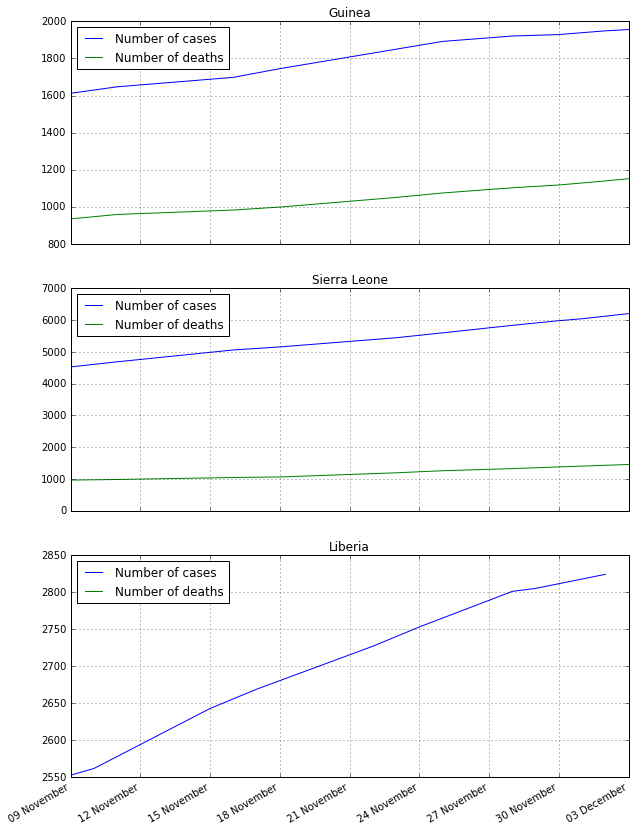

In [8]:
## Plot the graphs of 'Number of cases' and 'Number of deaths' by date for each of the 3 countries

import matplotlib.pyplot as plt    
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%d %B')
import numpy as np
%matplotlib inline

dff=DF_Combined[cols]
dff=dff.sort(columns=['COUNTRY (DISPLAY)','EBOLA_MEASURE (DISPLAY)','date'])
Countries=set(dff['COUNTRY (DISPLAY)'])
types=set(dff['EBOLA_MEASURE (DISPLAY)'])

fig, axarr = plt.subplots(3,sharex=True)
fig.set_size_inches(10,15)  
fig.autofmt_xdate()

i=0
for C in Countries:
    for t in types:
        data=dff[(dff['COUNTRY (DISPLAY)']==C)&(dff['EBOLA_MEASURE (DISPLAY)']==t)]
        # Convert date into date format
        D=data['date']
        X=[]
        for d in D:
            X.append(np.datetime64(d))
        # Convert the column 'Numeric' into float
        N=data['Numeric']
        Y =[]
        for n in N:
            try:
                Y.append(np.float(n))
            except:
                Y.append(2550)
        axarr[i].plot(X,Y)  
    axarr[i].xaxis.set_major_formatter(myFmt)
    # Use the country name as the title
    axarr[i].set_title(C)
    axarr[i].legend(types,loc='best')
    axarr[i].grid()
    i+=1
    

plt.show()
